In [1]:
import numpy as np
from numpy import random
import pandas as pd
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D

In [2]:
h  = 1

In [3]:
random.seed(h)

## Closed Form Equation of Statistical Features we approximate

In [4]:
def Entropy(eegData, bin_min, bin_max, binWidth=False):
    # For optimal bin-width:
    # Scott, D. 1979. On optimal and data-based histograms. Biometrika, 66:605-610.
    # Three assumptions were made to obtain the Scott's result. 
    # First, the Scott's result is asymptotically true (i.e. it is true for large sample size n). 
    # Second, the scaling exponent -1/3 is true if the density is a smooth function. 
    # Third, the coefficient 3.49 was obtained, assuming the Gauss density function as a reference. 
    # binWidth = 3.49/np.cbrt(N)
    if binWidth == False:
        binWidth = 3.49/np.cbrt(eegData.shape[1])
    H = np.zeros((eegData.shape[0], eegData.shape[2]))
    for chan in range(H.shape[0]):
        for epoch in range(H.shape[1]):
            counts, binCenters = np.histogram(eegData[chan,:,epoch], bins=np.arange(bin_min+1, bin_max, binWidth))
            nz = counts > 0
            prob = counts[nz] / np.sum(counts[nz])
            H[chan, epoch] = -np.dot(prob, np.log2(prob/binWidth))
    return H

In [21]:
def Kurtosis(eegData):
    return stats.kurtosis(scaled_arr,axis=1)

In [85]:
def Skew(eegData):
    return stats.skew(scaled_arr,axis=1)

In [ ]:
def Regularity(eegData):
    """
    Estimate frequency using autocorrelation
    Return 1/px instead of fs / px 
    """
    def ApEn(U, m, r) -> float:
    """Approximate_entropy."""
        def _maxdist(x_i, x_j):
            return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
        def _phi(m):
            m = int(m)
            x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
            C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
                for x_i in x]
            return (N - m + 1.0) ** (-1) * sum(np.log(C))
        N = len(U)
        return abs(_phi(m + 1) - _phi(m))
    """ Regularity Calculation """
    T = eegData.shape[1]
    H = np.zeros((eegData.shape[0], eegData.shape[2]))
    for chan in range(H.shape[0]):
        for epoch in range(H.shape[1]):
            H[chan,epoch] = ApEn(eegData[chan,:,epoch],T/5, 3)
    return H

In [97]:
# Z-scored np array
# T x Ch x Epochs
N = 500 # number of samples
E = 100 # Number of Epochs
input_arr = np.random.rand(N,1,E)
scaled_arr = np.zeros(input_arr.shape)
for ii in range(input_arr.shape[1]):
    scaler = StandardScaler()
    scaled_arr[:,ii,:] = scaler.fit_transform(input_arr[:,ii,:])

In [98]:
# Epochs X T X Ch
scaled_arr = np.moveaxis(scaled_arr,2,0)
scaled_arr.shape

(100, 500, 1)

In [99]:
do_cwt = True
if do_cwt:
    # Continuous wavelet transform
    flat_data = np.squeeze(scaled_arr)
    scaled_arr_cwt = []
    for ii in range(flat_data.shape[0]):
        widths = np.arange(1, 31)
        cwtmatr = cwt(flat_data[ii], ricker, widths)
        scaled_arr_cwt.append(np.moveaxis(cwtmatr,1,0))
    scaled_arr3d = np.stack(scaled_arr_cwt)
else:
    scaled_arr3d = scaled_arr
scaled_arr3d.shape

(100, 500, 30)

In [100]:
feature_res =np.squeeze(Skew(scaled_arr))

## Load random pre-generated FIN topology and train the model

In [126]:
def make_FIN(topology,size3D,N,name="my-FIN"):
    input_layer = keras.Input(shape=(N,size3D))
    x = Flatten()(input_layer)
    for layer in topology['layers']:
        x = Dense(layer['output_shape'], activation=layer['activation'])(x)
        if layer['BatchNorm']:
            x = BatchNormalization(axis=1)(x)
    fin_out = Dense(1, activation='linear')(x)
    fin = keras.Model(input_layer, fin_out, name=name)
    return fin

In [143]:
all_tp =  np.load('hyper_parameters.npy', allow_pickle=True)[()]
topology = all_tp[1]
fin = make_FIN(topology,30,N)

In [144]:
learning_rate=topology['lr']
momentum=topology['momentum']
nesterov=topology['nesterov']
b1 = topology['b1']
b2 = topology['b2']
if topology['opt'] == 'SGD':
    grad_desc_algorithm = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=momentum,nesterov=nesterov)
if topology['opt'] == 'ADAM':
    grad_desc_algorithm = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=b1,beta_2=b2)

In [ ]:
fin.compile(optimizer = grad_desc_algorithm,loss = topology['loss']) # Loss definitions
loss_d = fin.fit(scaled_arr3d, feature_res, # Fit on the dataset
            epochs = 10,
            batch_size = 500,
            verbose         = 1)              # display options to console

## Loading a Trained Model

In [26]:
from keras.models import load_model
import matplotlib.pyplot as plt

In [39]:
trained_model = load_model('./skew_dense_model_1.h5')

In [104]:
mod_res = trained_model.predict(scaled_arr3d[:20])

In [105]:
fet_res = feature_res[:20]

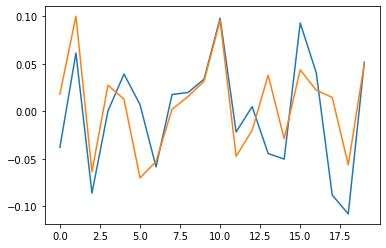

In [106]:
plt.plot(range(fet_res.size),mod_res,range(fet_res.size),fet_res)